Titanic dataset


In [20]:
#import titanic dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
import lightgbm as lgb



In [21]:
#import this file files/titanic3.xls into a dataframe
titanic = pd.read_excel('../files/titanic3.xls')
titanic.head()  

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Check for missing values

In [22]:
#check for missing values
titanic.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

There are 263 missing values in the Age column.
There are 1 missing values in the Fare column.
There are 1014 missing values in the Cabin column.
There are 2 missing values in the Embarked column.
There are 823 missing values in the Boat column.
There are 1188 missing values in the Body column.
There are 564 missing values in the home.dest column.
There are 2 missing values in the embarked column.

Since the many columns have missing values, I would have to drop them all except a column where I can fill with the mean of the column. So columns like Cabin, Boat, Body, home.dest would be dropped.

In [23]:
#delete features that are not useful
titanic.drop(['name','ticket','cabin','boat','body','home.dest','embarked','sibsp'], axis=1, inplace=True)
titanic.head()

,pclass,survived,sex,age,parch,fare
0,1,1,female,29.0000,0,211.3375
1,1,1,male,0.9167,2,151.5500
2,1,0,female,2.0000,2,151.5500
3,1,0,male,30.0000,2,151.5500
4,1,0,female,25.0000,2,151.5500


To make the dataset usable by a ML algorithm we have to change the categorical features into numerical features. So we have to change the gender in from male to female to 0 and 1 respectively. Also we have to change the Embarked column to numerical values. So we have to change the values in the Embarked column to 0, 1 and 2 respectively.

In [24]:
titanic['sex'] = titanic['sex'].replace({'male': 1, 'female': 0})

Lets have some insights on the data
Lets plot the survival of the sex 

<Axes: >

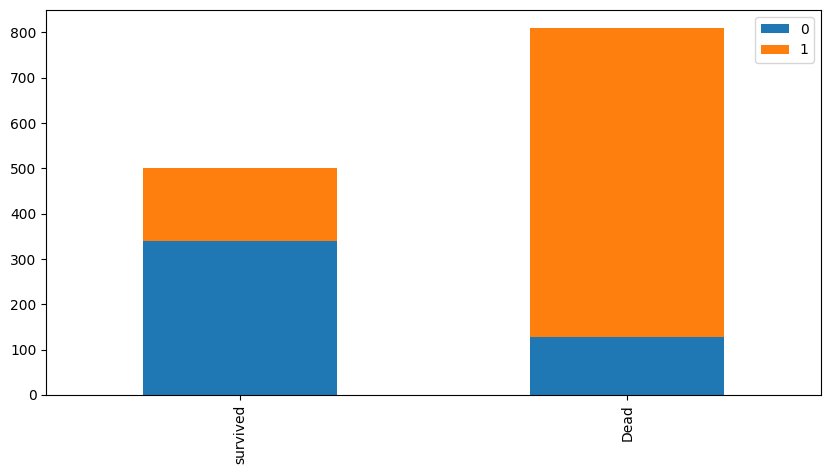

In [25]:

survived = titanic[titanic['survived']==1]["sex"].value_counts()
dead = titanic[titanic['survived']==0]["sex"].value_counts()
df = pd.DataFrame([survived,dead])
df.index = ['survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(10,5))


Plot the survival based on the classes of the ticket

<Axes: >

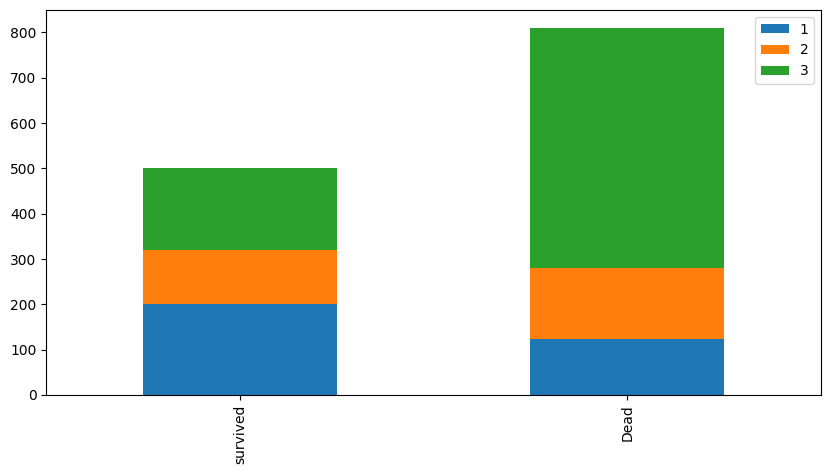

In [26]:
survived = titanic[titanic['survived']==1]["pclass"].value_counts().reindex([1, 2, 3])
dead = titanic[titanic['survived']==0]["pclass"].value_counts().reindex([1, 2, 3])
df = pd.DataFrame([survived,dead])
df.index = ['survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(10,5))

Drop unneccesary features from the dataset

In [27]:
titanic.head()

,pclass,survived,sex,age,parch,fare
0,1,1,0,29.0000,0,211.3375
1,1,1,1,0.9167,2,151.5500
2,1,0,0,2.0000,2,151.5500
3,1,0,1,30.0000,2,151.5500
4,1,0,0,25.0000,2,151.5500


In [28]:

# replace gender male to 1 and female to 0
titanic['sex'] = titanic['sex'].replace({'male': 1, 'female': 0})
titanic.head()


,pclass,survived,sex,age,parch,fare
0,1,1,0,29.0000,0,211.3375
1,1,1,1,0.9167,2,151.5500
2,1,0,0,2.0000,2,151.5500
3,1,0,1,30.0000,2,151.5500
4,1,0,0,25.0000,2,151.5500


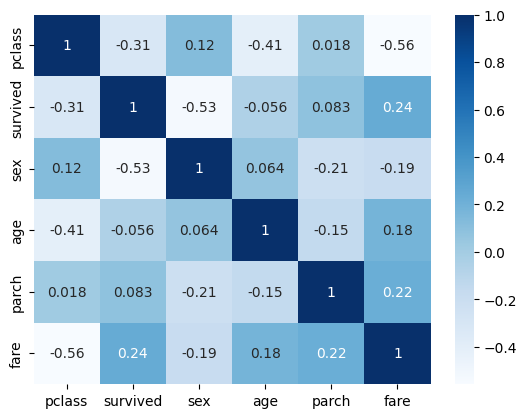

In [29]:
# Calculate the correlation matrix
corr = titanic.corr()
# Plot the heatmap
sns.heatmap(corr, annot=True, cmap="Blues")
plt.show()

In [30]:
#remove null values
titanic.dropna(inplace=True)
#see the number of rows and columns


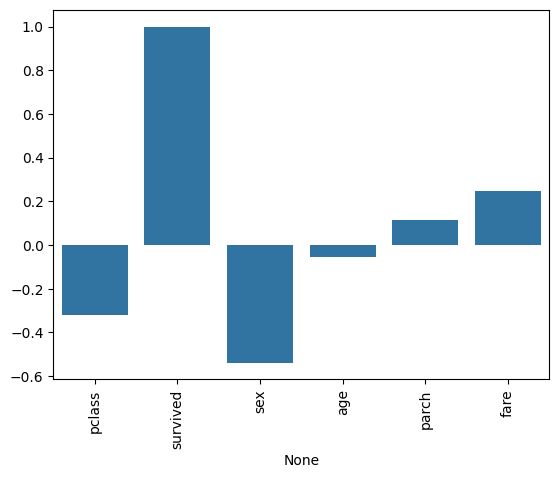

pclass     -0.319979
survived    1.000000
sex        -0.537719
age        -0.053958
parch       0.114091
fare        0.249164
dtype: float64


In [31]:
corr_matrix = titanic.corrwith(titanic['survived'])

sns.barplot(x=corr_matrix.index, y=corr_matrix.values)

plt.xticks(rotation=90)

plt.show()

print(corr_matrix)

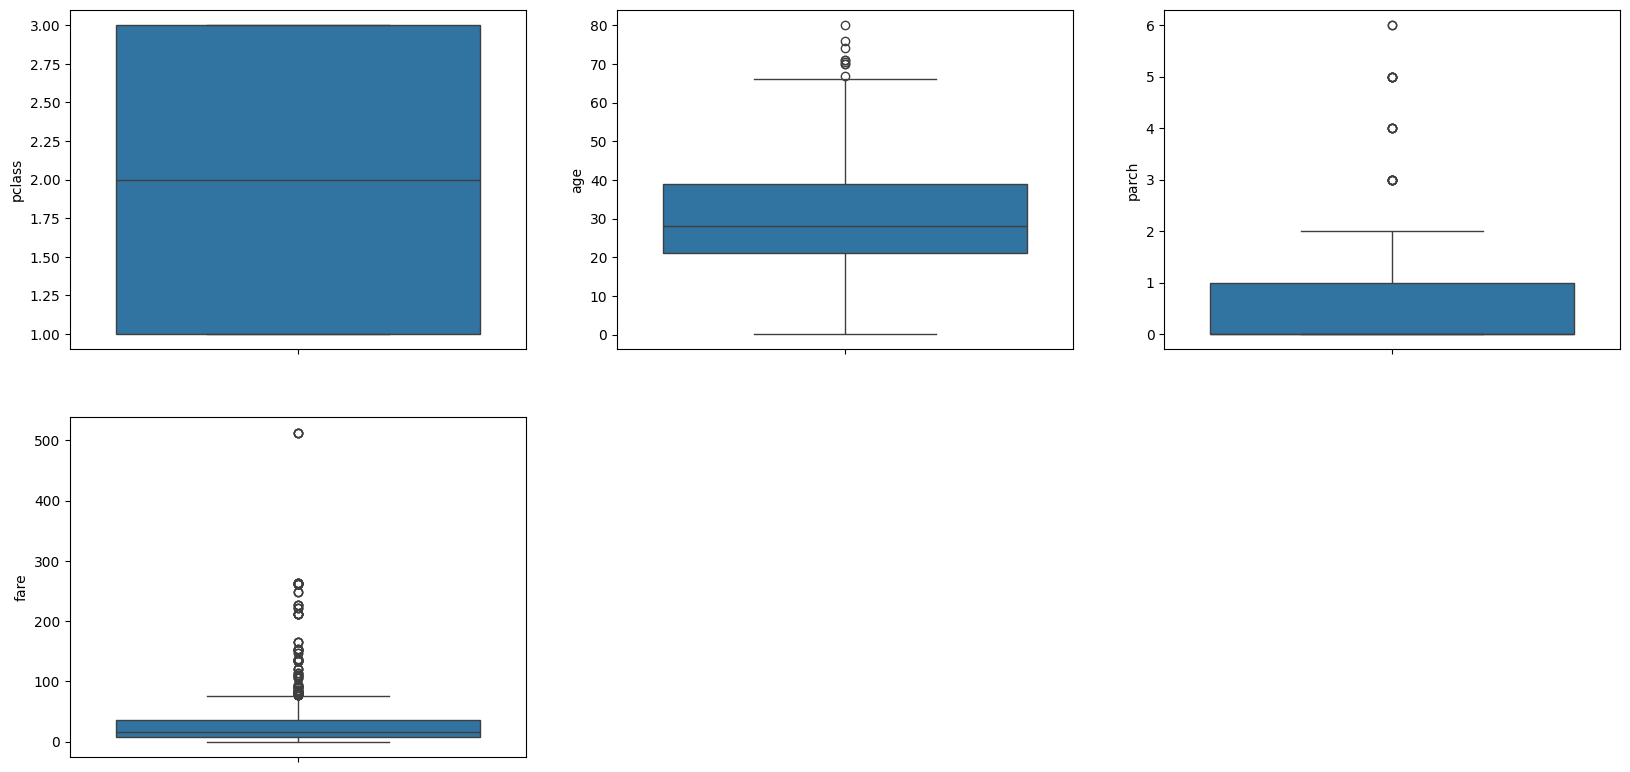

(1045, 6)

In [32]:
#plot a boxplot for all the features to see the outliers
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
sns.boxplot(titanic['pclass'])
plt.subplot(3,3,2)
sns.boxplot(titanic['age'])
plt.subplot(3,3,3)
sns.boxplot(titanic['parch'])
plt.subplot(3,3,4)
sns.boxplot(titanic['fare'])
plt.show()

#show the number of rows and columns
titanic.shape

Removing outliers from the dataset using the interquartile range caused the accuracy of my dataset to reduce. So I decided to leave the outliers in the dataset.

# calculate the IQR for each feature
Q1 = titanic.quantile(0.25)
Q3 = titanic.quantile(0.75)
IQR = Q3 - Q1

# remove the outliers
titanic = titanic[~((titanic < (Q1 - 1.5 * IQR)) |(titanic > (Q3 + 1.5 * IQR))).any(axis=1)]

titanic.shape

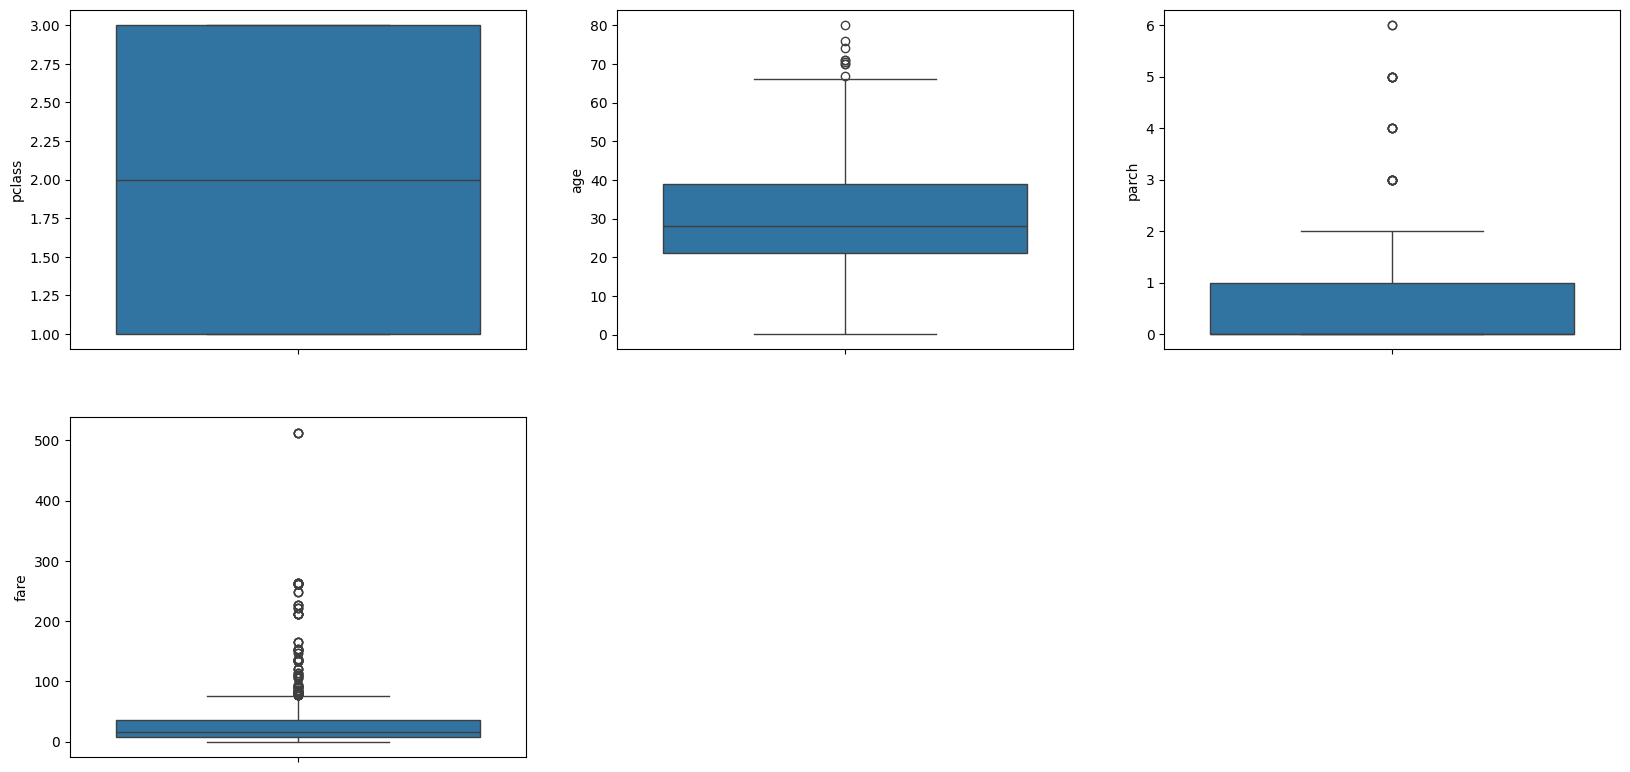

In [33]:
#plot a boxplot for all the features to see the outliers
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
sns.boxplot(titanic['pclass'])
plt.subplot(3,3,2)
sns.boxplot(titanic['age'])
plt.subplot(3,3,3)
sns.boxplot(titanic['parch'])
plt.subplot(3,3,4)
sns.boxplot(titanic['fare'])
plt.show()

In [34]:
feature_cols = ['pclass', 'age', 'parch', 'fare']

x = titanic[feature_cols]
y = titanic[['survived']] # target variable

In [35]:
# split x and y into training and testing sets
from sklearn.model_selection import train_test_split # import train_test_split function from sklearn

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25) # 75% training and 25% test

In [36]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_leaf_nodes': [31, 63, 127]
}

# Create a GradientBoostingClassifier
clf = GradientBoostingClassifier()

# Create a grid search CV object
model = GridSearchCV(clf, param_grid, cv=5)

# Fit the model to the training data
model.fit(X_train, y_train)

# Get the best hyperparameters
best_params = model.best_params_

# Evaluate the model on the test data
model = model.predict(X_test)
accuracy = accuracy_score(y_test, model)

print('Accuracy:', accuracy)



/Users/charlesnanakwakye/cloud_AI_Group4/venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesnanakwakye/cloud_AI_Group4/venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesnanakwakye/cloud_AI_Group4/venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesnanakwakye/cloud_AI_Group4/venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWar

Accuracy: 0.7022900763358778


/Users/charlesnanakwakye/cloud_AI_Group4/venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


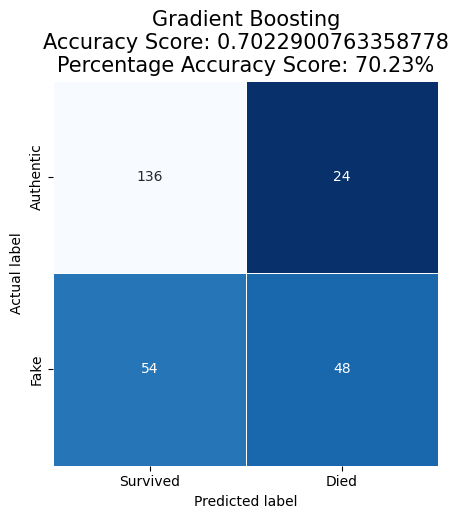

In [37]:
#generate a confusion matrix for the model
from sklearn.metrics import confusion_matrix




#print the confusion matrix

gradientBoostingAlgoPredCM = confusion_matrix(y_test, model)
plt.figure(figsize=(5,5))
sns.heatmap(gradientBoostingAlgoPredCM, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', cbar=False, xticklabels=['Survived', 'Died'], yticklabels=['Authentic', 'Fake'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

accuracy_score = metrics.accuracy_score(y_test, model)
percentage_accuracy_score = f'{accuracy_score:.2%}'
all_sample_title = f'Gradient Boosting\nAccuracy Score: {accuracy_score}\nPercentage Accuracy Score: {percentage_accuracy_score}'
plt.title(all_sample_title, size = 15)
plt.show()


In [38]:
# Save the models
import pickle
pickle.dump(model, open('saved_models/scikit_titanic_model.pkl', 'wb'))

